In [1]:
pip install biopython

  Using cached biopython-1.84-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.2 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pygraphviz

  Using cached pygraphviz-1.11-cp39-cp39-linux_x86_64.whl
Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio import Align
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import MinMaxScaler
import re
import os
import copy
import pickle
import gzip
import math
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
import pygraphviz
import datetime
date = datetime.datetime.now().strftime("%Y-%m-%d")
#from colorspacious import cspace_converter

In [4]:
#####
#output all dictionaries

def pickle_out(var,outfile):
    out,errors,names=[],[],[]
    with gzip.open('tmp', 'wb') as f:
        for k in var:
            if type(var[k]) is dict and not k.startswith('_'):
                try:
                    pickle.dump(var[k], f)
                    out.append(var[k])
                    names.append(k)
                    print(f'dump {k}')
                except:
                    errors.append(f"{k} failed")
    print(errors)
    f.close()
    names.append('save')
    out.append(names)
    with gzip.open(outfile, 'wb') as f:
        pickle.dump(out, f)
    f.close()
    print(len(out))
    
def pickle_load(file,prefix):
    with gzip.open(file, 'rb') as f:
        print(f'file {file} loaded')
        out=pickle.load(f)
    print([f"{prefix}_{i}"  for i in out[-1]])
    return out
##

#####
def get_gRNA_info (txt,adjust=0): #build dictionary from gRNA_with_expression files
    with open(txt) as handle:
        keys=[x for x in next(handle).strip('\n').split(' ') if x !='']
        gRNA_dict={f'gRNA_{i}': {i:j for i,j in zip(keys,[x for x in line.strip('\n').split(' ') if x !=''][1:])}for i,line in enumerate(handle)}
        for key in gRNA_dict:
            init_site=int(gRNA_dict[key]['mRNA_end'])+int(gRNA_dict[key]['rel_pos'])
            if gRNA_dict[key]['mRNA_name'] not in ['CYB','MURF2']:
                gRNA_dict[key]['gene_mRNA_end']=init_site+adjust
            else:
                gRNA_dict[key]['gene_mRNA_end']=init_site
    return(gRNA_dict)  
#get deletion and editing seuqences
def read_editing_sites(small_u):
    smallu=SeqIO.to_dict(SeqIO.parse(small_u,'fasta'))
    edits={}
    for k in smallu:
        sites=[0 if b=='u' else 1 for b in smallu[k].seq] #0 for insertions
        edits[k]=sites
    return(edits)
#deletion
def read_deletion_sites(deletion):
    deletion=SeqIO.to_dict(SeqIO.parse(deletion,'fasta'))
    delets={}
    for k in deletion:
        sites=[0 if b!='-' else 1 for b in deletion[k].seq] #0 for deletion sites
        delets[k]=sites
    return(delets)
#
#initiation site counts
def initiation_site_counts(gRNA_dict,small_u):
    insertions=read_editing_sites(small_u)
    mrna0={k:[0]*(len(insertions[k])+100) for k in insertions} #extend the mRNA a bit longer for the initiation sites
    anchors={k:[0]*(len(insertions[k])+100) for k in insertions}
    for k in gRNA_dict:
        init_site=gRNA_dict[k]['gene_mRNA_end']
        anc=int(gRNA_dict[k]['mRNA_start'])
        mrna0[gRNA_dict[k]['mRNA_name']][init_site]+=1
        anchors[gRNA_dict[k]['mRNA_name']][anc]+=1
    return(mrna0,anchors)
#visualize the boundaries
def slide_window_plot(inits,anchors,filename,ws=1,figw=100,figh=50):
    counts={k:[sum(inits[k][i:i+ws]) for i in range(len(inits[k])-ws)] for k in inits} #find initiation sites with window
    counts_a={k:[sum(anchors[k][i:i+ws]) for i in range(len(anchors[k])-ws)] for k in anchors} #find anchor starts with window
    c=0
    fig,axs = plt.subplots(len(counts),1,figsize=(figw,figh))
    for k in counts:
        ax=axs[c]
        ax.set_title(f'Initiation sites/anchor starts on {k}, window size= {ws}',fontdict={'fontsize': 30, 'fontweight': 30})
        c+=1
        #plot init sites
        ax.plot(range(len(counts[k])),counts[k],label=k)
        #plot anchors
        ax.plot(range(len(counts_a[k])),np.array(counts_a[k])*(-1),label=k)
        #find boundaries
        mrna=''.join([str(1) if i !=0 else str(0) for i in counts[k]])
        for match in re.finditer('(0){1,}',mrna):
            ax.add_patch(Rectangle((match.start(), 0), match.end()-match.start(), max(counts[k])+1,
                                  facecolor = 'black',alpha=0.3))
        #found boundaries with anchors
        mrna=''.join([str(1) if i!=0 else str(0) for i in counts_a[k]])
        for match in re.finditer('(0){1,}',mrna):
            ax.add_patch(Rectangle((match.start(), 0), match.end()-match.start(), (max(counts[k])+1)*(-1),
                                  facecolor = 'black',alpha=0.3))
    plt.savefig(filename)
    plt.show()
    return(counts)
#define gRNA family boundaries
#def gRNA_family_boundaries(counts):
#    gRNA_families={}
#    for k in counts:
#        #find boundaries
#        mrna=''.join([str(1) if i !=0 else str(0) for i in counts[k]]) #just 1 and 0 for the presence of init sites. real number count has 10 and can cause trouble
#        starts=[match.start() for match in re.finditer('0{4,}',mrna)] #change from 3 to 1
#        ends=[match.end() for match in re.finditer('0{4,}',mrna)]
#        boundaries=[(i,j) for i,j in zip(ends[:-1],starts[1:])]
#        gRNA_families[k]={f'{k}-{pair[0]}_{pair[1]}':{'bound':pair,'gRNA':[],'mRNA':k} for i,pair in enumerate(boundaries)}#
#        gRNA_families={m:{k: v for k, v in sorted(gRNA_families[m].items(), key=lambda item: item[1]['bound'][0])} for m in gRNA_families}
#        #print(gRNA_families)            
#    return(gRNA_families)
#assign gRNA families
def assign_gRNA_families(gRNA_dict,gRNA_families):
    for k in gRNA_dict:
        gRNA_dict[k]['gRNA_family']=[]
        hit=0
        for f in gRNA_families[gRNA_dict[k]['mRNA_name']]:
            bound=gRNA_families[gRNA_dict[k]['mRNA_name']][f]['bound']
            if int(gRNA_dict[k]['gene_mRNA_end']) >= bound[0] and int(gRNA_dict[k]['gene_mRNA_end']) <= bound[1]:
                gRNA_dict[k]['gRNA_family'].append(f)
                gRNA_families[gRNA_dict[k]['mRNA_name']][f]['gRNA'].append(k)
                hit+=1
                break
        if hit==0:
            print(f'error:cannot assign family for {k}')
            print(gRNA_dict[k])
    return(gRNA_dict,gRNA_families)
    
#character minicircles by gRNA family
def assign_gRNA_fam_to_mini(gRNA_dict,gRNA_families): #use the new version
    mini_dict,cassettes,non_cannonical={},['I','II','III','IV','V','Orphan'],[]
    for g in gRNA_dict:
        if gRNA_dict[g]['mO_name'] not in mini_dict:
            mini_dict[gRNA_dict[g]['mO_name']]={c:{} for c in cassettes}
            mini_dict[gRNA_dict[g]['mO_name']][gRNA_dict[g]['cassette_label']]=gRNA_dict[g]
        else:
            mini_dict[gRNA_dict[g]['mO_name']][gRNA_dict[g]['cassette_label']]=gRNA_dict[g]
    mini_dict.pop('Maxicircle','None') #remove maxicircle      
    mini_df = pd.DataFrame(columns=cassettes,index=mini_dict.keys())
    for mini in mini_dict:
        for c in mini_dict[mini]:
            try:
                mini_df.loc[[mini],[c]]=mini_dict[mini][c]['gRNA_family'][0]
            except:
                non_cannonical.append(f"no cannonical gRNA found in cassette {c} in minicircle {mini}")
    mini_df=mini_df.sort_values(by=cassettes)
    return(mini_dict,mini_df)
#group minicircles by gRNA family
def make_minicircle_family(mini_dict):
    mini_families={}
    for mini in mini_dict:
        hit=0
        #create a unique descriptor for each minicircle
        try:
            cs=';'.join([mini_dict[mini][c].get('gRNA_family','n')[0] for c in mini_dict[mini]])
            if cs not in mini_families:
                mini_families[cs]=[]
                mini_families[cs].append(mini)
            else:
                mini_families[cs].append(mini)
        except:
            print(f'error for {mini}')
    #sort by the number of encoded gRNAs
    tmp={k:k.count('n') for k in mini_families}
    tmp={k: v for k, v in sorted(tmp.items(), key=lambda item: item[1])}
    ordered=list(tmp.keys())
    mini_families={k:mini_families[k] for k in ordered}
    return(mini_families)

#gRNA family and minicircle family stats
def gRNA_family_stats(gRNA_dict,gRNA_families, figw=25,figh=50): #use the new version
    #presence in multiple cassettes
    x,y,z=[],[],[]
    fig,axs = plt.subplots(2,3,figsize=(figw,figh))
    for k in gRNA_families:
        for f in gRNA_families[k]:
            y.append(len(gRNA_families[k][f]['gRNA']))
            z.append(len(set([gRNA_dict[g]['mO_name'] for g in gRNA_families[k][f]['gRNA']])))
            cst={}
            for g in gRNA_families[k][f]['gRNA']:
                l=gRNA_dict[g]['cassette_label']
                if l not in cst:
                    cst[l]=1
                else:
                    cst[l]+=1
            gRNA_families[k][f]['cassettes']=cst
            x.append(len(cst))
            #if len(cst)>1:
                #print(k,cst)
    ax=axs[0,0]
    ax.hist(x,bins=np.array(range(0,(max(x)+1)*2,1))/2) #np array can be used as a vector
    ax.set_xlabel('presence in number of different cassettes')
    ax.set_ylabel('number of gRNA family')
    #how many gRNAs are in one gRNA fam
    ax=axs[0,1]
    ax.hist(y,bins=np.array(range(0,(max(y)+1)*2,1))/2) #np array can be used as a vector
    ax.set_xlabel('number of gRNAs in each gRNA family')
    ax.set_ylabel('number of gRNA family')
    #how many minicircles contain the same gRNA family
    ax=axs[0,2]
    ax.hist(z,bins=np.array(range(0,(max(z)+1)*2,1))/2) #np array can be used as a vector
    ax.set_xlabel('presence in minicircles')
    ax.set_ylabel('number of gRNA family')
    #how many minicircles families contain the same gRNA family
    ax=axs[1,0]
    mf=[len(gRNA_families[k][gf].get('minicircle_family','n')) for k in gRNA_families for gf in gRNA_families[k]]
    ax.hist(mf,bins=np.array(range(0,(max(mf)+1)*2,1))/2) #np array can be used as a vector
    ax.set_xlabel('presence in minicircles families')
    ax.set_ylabel('number of gRNA family')
    #length distribution of gRNA families (boundary length)
    gflen=[((gRNA_families[k][gf]['bound'][1]-gRNA_families[k][gf]['bound'][0]),len(gRNA_families[k][gf]['cassettes'])) for k in gRNA_families for gf in gRNA_families[k]]
    len_c={i+1:{c:0 for c in [1,2,3,4,5,6]} for i in range(0,(max([i[0] for i in gflen])+1),1)}
    for boundary in gflen:
            for k in len_c:
                if boundary[0]==k:
                    len_c[k][boundary[1]]+=1
    ax=axs[1,1]
    ax.hist([i[0] for i in gflen],bins=np.array(range(0,(max([i[0] for i in gflen])+1),1))) #np array can be used as a vector
    ax.set_xlabel('length of initiation site boundaries')
    ax.set_ylabel('number of gRNA family')
    ax=axs[1,2]
    df=pd.DataFrame.from_dict(len_c,orient='index')
    ax.bar(df.index, (df[1]), label='1',color='blue')
    ax.bar(df.index, (df[2]),bottom=(df[1]),label='2',color='cornflowerblue')
    ax.bar(df.index, (df[3]),bottom=(df[1]+df[2]),label='3',color='dodgerblue')
    ax.bar(df.index, (df[4]),bottom=(df[1]+df[2]+df[3]),label='4',color='steelblue')
    ax.bar(df.index, (df[5]),bottom=(df[1]+df[2]+df[3]+df[4]),label='5',color='skyblue')
    ax.bar(df.index, (df[6]),bottom=(df[1]+df[2]+df[3]+df[4]+df[5]),label='6',color='lightcoral')
    #legend
    handles1, labels1 = ax.get_legend_handles_labels()
    by_label = dict(zip(labels1, handles1))
    leg=ax.legend(by_label.values(), by_label.keys(),fontsize=20,bbox_to_anchor=(0.14, -0.15))
    ax.set_xlabel('initiation site boundary length')
    ax.set_ylabel('number of gRNA families')
    #another figure
    fig,axs = plt.subplots(2,1,figsize=(figw,figh))
    #number of gRNA families for each mRNA,seperated by cassettes
    g_f=[len(gRNA_families[k]) for k in gRNA_families] 
    mrna=[k for k in gRNA_families]
    ax=axs[0]
    ax.bar(mrna,g_f)
    #number of gRNA for each mRNA,seperated by cassettes
    mrna_cst,cassettes={},['I','II','III','IV','V','Orphan']
    for k in gRNA_families:
        mrna_cst[k]={c:0 for c in cassettes}
        for f in gRNA_families[k]:
            for g in gRNA_families[k][f]['gRNA']:
                if gRNA_dict[g]['cassette_label'] in mrna_cst[k]:
                    mrna_cst[k][gRNA_dict[g]['cassette_label']]+=1
    df=pd.DataFrame.from_dict(mrna_cst,orient='index')
    print(df)
    ax=axs[1]
    ax.bar(df.index, (df['I']), label='I',color='blue')
    ax.bar(df.index, (df['II']),bottom=(df['I']),label='II',color='cornflowerblue')
    ax.bar(df.index, (df['III']),bottom=(df['I']+df['II']),label='III',color='dodgerblue')
    ax.bar(df.index, (df['IV']),bottom=(df['I']+df['II']+df['III']),label='IV',color='steelblue')
    ax.bar(df.index, (df['V']),bottom=(df['I']+df['II']+df['III']+df['IV']),label='V',color='skyblue')
    ax.bar(df.index, (df['Orphan']),bottom=(df['I']+df['II']+df['III']+df['IV']+df['V']),label='Orphan',color='lightcoral')
    ax.set_xlabel('mRNAs')
    ax.set_ylabel('number of gRNA')
    #legend
    handles1, labels1 = ax.get_legend_handles_labels()
    by_label = dict(zip(labels1, handles1))
    leg=ax.legend(by_label.values(), by_label.keys(),fontsize=20,bbox_to_anchor=(0.14, -0.15))
    plt.show()

#list gRNA families of interest
def output_gRNA_families(gRNA_families2,gRNA_dict,threshold=6):
    grna_families={g:gRNA_families2[k][g] for k in gRNA_families2 for g in gRNA_families2[k]}
    #gRNA families that present in multiple cassettes
    multi={gf:len(grna_families[gf]['cassettes']) for gf in grna_families if len(grna_families[gf]['cassettes'])>1}
    multi={k: v for k, v in sorted(multi.items(), key=lambda item: item[1])}
    print(f"gRNA families detected in multiple cassettes:\n{multi}")
    #gRNA families that are present in the most minicircles
    many={gf:len(grna_families[gf]['gRNA']) for gf in grna_families if len(grna_families[gf]['gRNA'])>=threshold}
    many={k: v for k, v in sorted(many.items(), key=lambda item: item[1])}
    print(f"gRNA families present in more than {threshold} minicircles:\n{many}")
            
#combine the same gRNA in v1 v2
def combine_alternatives(gRNA_dict):
    alt,paired={},[]
    other={g:gRNA_dict[g] for g in gRNA_dict if '_v' not in gRNA_dict[g]['mRNA_name']}
    v1={g:gRNA_dict[g] for g in gRNA_dict if '_v1' in gRNA_dict[g]['mRNA_name']}
    v2={g:gRNA_dict[g] for g in gRNA_dict if '_v2' in gRNA_dict[g]['mRNA_name']}
    print('number of gRNAs for v1 and v2 mRNAs',len(v1),len(v2))
    for g1 in v1:
        for g2 in v2:
            if v1[g1]['mO_name']==v2[g2]['mO_name'] and v1[g1]['cassette_label']==v2[g2]['cassette_label'] and v1[g1]['product']==v2[g2]['product']:
                dcs=int(v1[g1]['circle_start'])-int(v2[g2]['circle_start'])
                dce=int(v1[g1]['circle_end'])-int(v2[g2]['circle_end'])
                if dcs>2 or dce>2:
                    #this is just for manual checking
                    print('paired gRNA with >2bp difference on minicircle:',v1[g1]['name'],v2[g2]['name'])
                paired.append(g2)
                alt[g1]=g2
    v2={k:v2[k] for k in v2 if k not in paired}
    uv2={k:v for k,v in v2.items() if k not in alt.values()}
    uv1={k:v for k,v in v1.items() if k not in alt.keys()}
    print('number of gRNAs only in v1 or in v2',len(uv1),len(uv2))
    print('\ndistinct gRNAs for alternatively edited mRNAs:')
    for k in v2:
        print(v2[k]['name'])
    v1.update(v2) #old
    v1.update(other) #old
    print(f"number of gRNAs after removing repetitive ones for different versions: {len(v1)}")
    shared={k.replace('_v1',''):v for k,v in v1.items() if k in alt.keys()}
    shared.update(uv1)
    shared.update(uv2)
    shared.update(other)
    return(v1) #old

#visualization and validation of gRNA families
def gRNA_family_validation(gRNA_dict2,gRNA_families2,filename,figw=50,figh=50,floor=-20):
    c=0
    insertions=read_editing_sites(small_u) #1 for insertions
    dels=read_deletion_sites(deletion) #0 for deletion sites
    fig,axs = plt.subplots(len(gRNA_families2),1,figsize=(figw,figh))
    for k in gRNA_families2:
        ax,d=axs[c],0
        c+=1
        ax.set_title(f'distribution of gRNA families on {k}',fontdict={'fontsize': figh/5, 'fontweight': figh/5})
        ax.set_xlim(left=0,right=len(insertions[k]))
        #ax.set_xlim(len(insertions[k])) #can flip x_axis
        #draw insertion sites: 0 for insertions
        x=[i for i,c in enumerate(insertions[k]) if c==0 ] 
        y=[d]*len(x)
        ax.scatter(x,y,marker=3,color='purple',linewidth=5)
        d+=-1
        #ax.text(-10,0,"insertions",fontsize=25)
        #draw deletions
        x=[i for i,c in enumerate(dels[k]) if c==0 ] 
        y=[d]*len(x)
        ax.scatter(x,y,marker=3,color='red',linewidth=5)
        d+=-1
        #ax.text(-10,-1,"deletions",fontsize=25)
        #draw gRNA families
        ceiling=d
        for gf in gRNA_families2[k]:
            #ax.text(gRNA_families2[k][gf]['bound'][1],d,f"{k} init range: {gRNA_families2[k][gf]['bound']}")
            ax.text(gRNA_families2[k][gf]['bound'][1],d,f"{gf}")
            for g in gRNA_families2[k][gf]['gRNA']:
                ms=int(gRNA_dict2[g]['mRNA_start'])
                me=int(gRNA_dict2[g]['mRNA_end'])
                al=int(gRNA_dict2[g]['anchor_len'])
                ie=int(gRNA_dict2[g]['gene_mRNA_end'])
                ax.add_patch(Rectangle((ms, d), me-al-ms, -1,
                                  facecolor = 'black',alpha=0.1)) #coding region
                ax.add_patch(Rectangle((me-al, d), al, -1,
                                  facecolor = 'red',alpha=0.1)) #anchor
                ax.add_patch(Rectangle((me, d), ie-me, -1,
                                  facecolor = 'blue',alpha=0.1)) #init sequence
            d+=-2
            if d <floor:
                d=ceiling
    plt.savefig(filename)
    plt.show()
#manually combine gRNA families based on gRNA family distribution
def manual_merge_gRNA_fam(gRNA_families2, clusters=[[]]):
    grna_families={g:gRNA_families2[k][g] for k in gRNA_families2 for g in gRNA_families2[k]}#change the structure for convenience
    print('total gRNA family: ',len(grna_families))
    for cluster in clusters:
        lower_bound,upper_bound,gRNA,cassettes=[],[],[],{}
        try:
            for gf in cluster:
                mrna=grna_families[gf]['mRNA']
                lower_bound.append(grna_families[gf]['bound'][0])
                upper_bound.append(grna_families[gf]['bound'][1])
                gRNA+=grna_families[gf]['gRNA']
                for c in grna_families[gf]['cassettes']:
                    if c in cassettes:
                        cassettes[c]+=grna_families[gf]['cassettes'][c]
                    else:
                        cassettes[c]=grna_families[gf]['cassettes'][c]
                grna_families.pop(gf)
            grna_families[f'{mrna}-{min(lower_bound)}_{max(upper_bound)}']={'bound':(min(lower_bound),max(upper_bound)),
                                                                    'gRNA':gRNA,'mRNA':mrna,'cassettes':cassettes}
        except:
            print(f"{cluster} already merged")
    print('after merging:', len(grna_families))
    gfam_update={grna_families[g]['mRNA']:{} for g in grna_families}
    for g in grna_families:
        gfam_update[grna_families[g]['mRNA']][g]=grna_families[g]
    print('output update',sum([len(gfam_update[k]) for k in gfam_update]))
    return(gfam_update)



#an updated method for finding connections between minicircles
def connect_mini(mini_dict,mini_families):
    connections,shared,renamed={},{},{}
    for i,f in enumerate(mini_families):
        renamed[f"mFam_{i}"]={'cassettes':f,'class':mini_families[f]}
    #rename minicircle families in connections
    for f1 in renamed:
        connections[f1]={'sup_fam1':[],'sup_fam2':[],'sup_fam3':[],'sup_fam4':[]}
        shared[f1]={}
        for f2 in renamed:
            if f1 !=f2:
                hits=[]
                for i,j in zip(renamed[f1]['cassettes'].split(';'),renamed[f2]['cassettes'].split(';')):
                    if i==j and i!='n':
                        hits.append('h') #'H': hit of cannonical cassettes
                    elif i==j and i=='n':
                        hits.append('nb') #nb: noncanonical cassettes in both
                    elif i=='n' and j!='n':
                        hits.append('n1') #ns: noncanonical in subject fam
                    elif i!='n' and j=='n':
                        hits.append('n2') #nf: noncannonical in query fam
                    else:
                        hits.append('m') #m:mismatch
                #if contains or is the subset of another minicircle family
                if 'h' in hits and 'm' not in hits and ('n1' not in hits or 'n2' not in hits): 
                    connections[f1]['sup_fam1'].append(f2)
                #if no mismatches
                elif 'h' in hits and 'm' not in hits:
                    connections[f1]['sup_fam2'].append(f2)
                #if shares >1 gRNA family and has <=1 mismatches
                elif hits.count('h')>1 and hits.count('m') <=1:
                    connections[f1]['sup_fam3'].append(f2)
                #if shares 1 gRNA family and has <=1 mismatches
                elif hits.count('h')>=1 and hits.count('m') <=1:
                    connections[f1]['sup_fam4'].append(f2)
                #another way to characterize similarity: shared gFam
                if hits.count('h')>0:
                    shared[f1][f2]={'h':hits.count('h'),'m':hits.count('m')}
    return(connections,shared,renamed)

def gRNA_within_fam_similarity(gRNA_dict,gRNA_fam,filename,figw=30,figh=6):
    aligner = Align.PairwiseAligner(scoring="blastn")
    new,i={k:gRNA_fam[k] for k in gRNA_fam if len(gRNA_fam)>0},0
    fig,axs = plt.subplots(len(new),1,figsize=(figw,figh))
    for k in new:
        positions=[gRNA_fam[k][gf]['bound'][0] for gf in gRNA_fam[k] if len(gRNA_fam[k][gf]['gRNA'])>1]
        identities=[[max([round(a.counts().identities/a.shape[1],2)*100 for a in aligner.align(gRNA_dict[g1]['gRNA_seq'].replace('U','T'),gRNA_dict[g2]['gRNA_seq'].replace('U','T'))]) 
           for g2 in gRNA_fam[k][gf]['gRNA'] for g1 in gRNA_fam[k][gf]['gRNA'] if g1 != g2]
           for gf in gRNA_fam[k] if len(gRNA_fam[k][gf]['gRNA'])>1]
        if len(identities)!=0:
            ax=axs[i]
            ax.boxplot(identities,positions=positions)
            ax.plot(positions, [np.mean(v) for v in identities],color='orange')
            ax.axhline(y=50, xmin=0, xmax=max(positions)+20,ls='--')
            ax.axhline(y=80, xmin=0, xmax=max(positions)+20,ls='--')
            ax.set_ylim(0,100)
            ax.set_xlim(0,max(positions)+20)
            ax.set_xticklabels(positions, rotation=90)
            ax.set_xlabel('Position on mRNA')
            ax.set_ylabel('Percent Identity')
            ax.set_title(f'Percent Identity of gRNAs within gRNA families on {k}')
        else:
            print(k)
        i+=1
    plt.savefig(filename)
    plt.show()

def check_gRNA_number(gRNA_dict,gRNA_families):
    in_fam=sum([len(gRNA_families[k][gf]['gRNA']) for k in gRNA_families for gf in gRNA_families[k]])
    print(f'number of gRNA in gRNA family dict: {in_fam} \nnumber of gRNA in gRNA dict:{len(gRNA_dict)}')

#merge gRNA families that are too short and single
def merge_gRNA_fam(gRNA_dict,gRNA_fam):
    gRNA_fam={m:{k: v for k, v in sorted(gRNA_fam[m].items(), key=lambda item: item[1]['bound'][0])} for m in gRNA_fam}
    new=copy.deepcopy(gRNA_fam)
    for k in gRNA_fam:
        ks=list(gRNA_fam[k].keys())
        for gf in gRNA_fam[k]:
            if ks.index(gf) < len(ks)-1:# and len(gRNA_fam[k][gf]['gRNA'])==1: #except the last one
                i=ks.index(gf)
                g5=min([int(gRNA_dict[g]['mRNA_start']) for g in gRNA_fam[k][gf]['gRNA']])
                b5=min([int(gRNA_dict[g]['mRNA_start']) for g in gRNA_fam[k][ks[i+1]]['gRNA']])
                g3=max([int(gRNA_dict[g]['gene_mRNA_end']) for g in gRNA_fam[k][gf]['gRNA']])
                b3=max([int(gRNA_dict[g]['gene_mRNA_end']) for g in gRNA_fam[k][ks[i+1]]['gRNA']])
                if b5 <= g5 and b3>= g3:
                    new[k][ks[i+1]]['gRNA']+=new[k][gf]['gRNA']
                    new[k][ks[i+1]]['bound']=(min([new[k][ks[i+1]]['bound'][0],new[k][ks[i]]['bound'][0]]),max([new[k][ks[i+1]]['bound'][1],new[k][ks[i]]['bound'][1]]))
                    #gRNA_fam[k][ks[i+1]]['gRNA'].append(gRNA_fam[k][gf]['gRNA'][0]) #but not updating the bound info
                    for grna in new[k][gf]['gRNA']:
                        gRNA_dict[grna]['gRNA_family']=ks[i+1] #gRNA_fam[k][ks[i+1]]
                    #print(ks[i+1])
                    del new[k][gf]
    del gRNA_fam
    return(new)

def add_mini_fam_info(gRNA_fam,gRNA_dict,mini_fam):
    tmp={m:k for k in mini_families for m in mini_families[k]}
    for k in gRNA_fam:
        for gf in gRNA_fam[k]:
            #try:
            mf=list(set([tmp.get(gRNA_dict[g]['mO_name'],'Maxicircle') for g in gRNA_fam[k][gf]['gRNA']]))
            gRNA_fam[k][gf]['minicircle_family']=mf
            #except:
            #    print(gRNA_dict[gRNA_fam[k][gf]['gRNA'][0]])

#plot initiation sites of gRNA families
def plot_initiation_sites(counts,gRNA_fam,gRNA_dict,combined,outfile,figw=100,figh=50):
    c,c_dict,gf_presence=0,{'I':'r','II':'skyblue','III':'orange','IV':'purple','V':'green','Orphan':'black'},{}
    fig,axs = plt.subplots(len(counts),1,figsize=(figw,figh))
    mini_presence={mini: [idx for idx in combined[mini][~(combined[mini].isna())].index] for mini in combined.columns}
    #in how many strains is each gf present
    for k in gRNA_fam:
        for gf in gRNA_fam[k]:
            total=[]
            for g in gRNA_fam[k][gf]['gRNA']:
                mini=gRNA_dict[g]['mO_name']
                total+=mini_presence.get(mini,[])
            total=set(total)
            gf_presence[gf]=round(len(total)/len(combined),2) #the ratio is used to color the patches for each gf
    ##
    for k in counts:
        ax=axs[c]
        ax.set_title(f'Initiation site starts on {k}',fontdict={'fontsize': 30, 'fontweight': 30})
        c+=1
        #plot init sites
        ax.plot(range(len(counts[k])),counts[k],label=k)
        ax.axhline(y=1, xmin=0, xmax=len(counts[k]),ls='--')
        #ax.set_ylim(-10,max(counts[k])+1)
        #plot boundaries
        try:
            maximum=max([len(gRNA_fam[k][gf]['gRNA']) for gf in gRNA_fam[k]])
        except: #COX2 has no gRNA annotated
            maximum=1
        for gf in gRNA_fam[k]:
            gc={}
            ax.add_patch(Rectangle((gRNA_fam[k][gf]['bound'][0], 0), gRNA_fam[k][gf]['bound'][1]-gRNA_fam[k][gf]['bound'][0], max(counts[k])+1,
                                  facecolor = 'black',alpha=gf_presence[gf]*0.3))
            ax.text(gRNA_fam[k][gf]['bound'][0],max(counts[k][gRNA_fam[k][gf]['bound'][0]:gRNA_fam[k][gf]['bound'][1]])+2,f"{100*gf_presence[gf]}%") #annotate the percentage of strains that have the gf
            ax.text(gRNA_fam[k][gf]['bound'][0],0,f"{gRNA_fam[k][gf]['bound'][0]}\nmf#:{len(gRNA_fam[k][gf].get('minicircle_family',['Maxi']))}")
            for g in gRNA_fam[k][gf]['gRNA']:
                if gRNA_dict[g]['gene_mRNA_end'] in gc:
                    gc[gRNA_dict[g]['gene_mRNA_end']].append(gRNA_dict[g]['cassette_label'])
                else:
                    gc[gRNA_dict[g]['gene_mRNA_end']]=[]
                    gc[gRNA_dict[g]['gene_mRNA_end']].append(gRNA_dict[g]['cassette_label'])
            gc={k:gc[k] for k in gc} #plot the same position twice
            for init in gc:
                h=-0.4
                for cass in gc[init]:
                    if cass!='Maxi':
                        ax.scatter([init],[h],color=c_dict[cass])
                        h+=(-0.5)
    plt.savefig(filename)
    plt.show()

    
def pickle_load(file):
    with gzip.open(file, 'rb') as f:
        print(f'file {file} loaded')
        gRNA_dict=pickle.load(f)
    return gRNA_dict

def with_a6_rps12(mini_fam):
    a6rps12={k:mini_fam[k] for k in mini_fam if 'A6' in mini_fam[k]['cassettes'] or 'RPS12' in mini_fam[k]['cassettes']}
    print(len(mini_fam),len(a6rps12),round(len(a6rps12)/len(mini_fam),2)*100)        

#load metadata
def process_df(csv,meta2):
    df=pd.read_csv(csv,index_col=0)#.rename(columns=df.iloc[0]).drop(df.index[0])
    df=df.drop(['MSUS-CI-78-TSW390','GUIWI-BOBO80-MURAZ18','SN54-TREU96']) #remove the known contaminated samples and Tbeq
    #clean up metadata
    meta2='/home/jovyan/Minicircle_gRNA_families/In_files/updated_metadata_isolates 2022-01-09.csv'
    metadf2=pd.read_csv(meta2,index_col=0,encoding='cp1252') #not utf8 encoding
    metadf2=metadf2.drop(['MSUS-CI-78-TSW390','GUIWI-BOBO80-MURAZ18','SitaBip1','SN54-TREU96','ABBA_b'])
    metadf2['taxon']=metadf2['taxon'].fillna('T. brucei').replace('T.b.','T. brucei')
    metadf2.rename(columns={'Year of isolation ': 'Year of isolation'}, inplace=True)
    metadf2['continent']=metadf2['continent'].fillna('na').replace('Southern Africa\xa0','Southern Africa')
    metadf2['country']=metadf2['country'].fillna('na')
    metadf2['Year of isolation']=metadf2['Year of isolation'].fillna('na')
    for s in ['MHOM-CI-78-DALOA72-cloneA','MHOM-CI-79-DALOA74','MHOM-CI-91-SIQUE1623','MHOM-ZR-71-C126','MSUS-CI-82-TSW125-KP1-cloneB']:
        metadf2.loc[s,'taxon']='T.b. gambiense type I'
    for s in ['MSUS-CI-78-TSW168']:
        metadf2.loc[s,'taxon']='T.b. gambiense type II'
    for s in ['MSUS-CI-78-TSW178','MSUS-CI-78-TSW38-021','MSUS-CI-78-TSW382-bis']:
        metadf2.loc[s,'taxon']='T.b. brucei'
    #Zambia is assigned to EA and SA --> assign all Zambia to SA
    for s in metadf2[metadf2.apply(lambda x:x['country']=='Zambia' and x['continent']=='East Africa', axis=1)].index:
        metadf2.loc[s,'continent']='Southern Africa'
    #ignore Tbeq Tbev data for now
    metadf2=metadf2.loc[metadf2.index.intersection(df.index)]
    #combine
    combined=pd.concat([df,metadf2], axis=1) #append won't change the order of columns (no auto sorting)
    renames=rename_strain(combined)
    combined['renamed']=renames
    combined=combined.set_index('renamed')
    return(metadf2,combined)
#rename the strains
def rename_strain(df):
    new=[]
    taxon_dict={'T.b. gambiense type I':'TbgI','T.b. gambiense type II':'TbgII',
                              'T.b. brucei':'Tbb','T.b. rhodesiense':'Tbr',
                             'T.b.':'Tb','T. brucei':'Tb'}
    for i,j in zip(df.index,df['taxon']):
        if j in taxon_dict:
            new.append(f'{taxon_dict[j]}_{i}')
        else:
            new.append(f'Tb_{i}')
    return(new)
#
def strain_mini(combined):
    strain_mini_sets={strain: [idx for idx in combined.loc[strain][~(combined.loc[strain].isna())].index if 'Tb_mO' in idx] for strain in combined.index}
    return(strain_mini_sets)

#not sure if this function actually does anything
def find_init_position(gRNA_dict):
    for key in gRNA_dict:
        init_site=int(gRNA_dict[key]['mRNA_end'])+int(gRNA_dict[key]['rel_pos'])
        gRNA_dict[key]['gene_mRNA_end']=init_site

In [5]:
def init_grna_comb(counts,gRNA_fam,gRNA_dict,gf_presence,outfile,figw=100,figh=50,floor=-20,color_by_subspecies=False):
    taxon_dict={'TbgI':'red','TbgII':'violet','Tbb':'skyblue','Tbr':'green','Tb':'black'}
    c,c_dict=0,{'I':'r','II':'skyblue','III':'orange','IV':'purple','V':'green','Orphan':'black'}
    insertions=read_editing_sites(small_u) #1 for insertions
    dels=read_deletion_sites(deletion) #0 for deletion sites
    fig,axs = plt.subplots(len(counts),1,figsize=(figw,figh))
    for k in counts:
        ax,d=axs[c],0
        ax.set_title(f'Initiation site starts on {k}',fontdict={'fontsize': 30, 'fontweight': 30})
        c+=1
        #plot init sites
        #ax.plot(range(len(counts[k])),counts[k],label=k)
        ax.set_xlim(left=0,right=len(insertions[k])+60)
        #plot boundaries
        if color_by_subspecies==True:
            #color by dominant subspecies of minicircle
            for gf in gRNA_fam[k]:
                gc={}
                ax.add_patch(Rectangle((gRNA_fam[k][gf]['bound'][0], 0), gRNA_fam[k][gf]['bound'][1]-gRNA_fam[k][gf]['bound'][0], max(counts[k])+1,
                                      facecolor = 'black',alpha=gf_presence[gf]*0.3))
                ax.text(gRNA_fam[k][gf]['bound'][0],1,f"{gRNA_fam[k][gf]['bound'][0]}")
                #annotate the percentage of strains that have the gf
                ax.text(gRNA_fam[k][gf]['bound'][0],max(counts[k][gRNA_fam[k][gf]['bound'][0]:gRNA_fam[k][gf]['bound'][1]])+2,f"{100*gf_presence[gf]}%") 
                for g in gRNA_fam[k][gf]['gRNA']:
                    if gRNA_dict[g]['gene_mRNA_end'] in gc:
                        gc[gRNA_dict[g]['gene_mRNA_end']].append(gRNA_dict[g]['mO_name'])
                    else:
                        gc[gRNA_dict[g]['gene_mRNA_end']]=[]
                        gc[gRNA_dict[g]['gene_mRNA_end']].append(gRNA_dict[g]['mO_name'])
                gc={k:gc[k] for k in gc} #plot the same position twice
                for init in gc:
                    h=0.4
                    for mini in gc[init]:
                        if 'Maxi' not in mini:
                            if mini_dominant_sp[mini][1]>=0.7:
                                color=taxon_dict[mini_dominant_sp[mini][0]]
                            else:
                                color='black'
                            ax.scatter([init],[h],color=color)
                            h+=(1)
        else:
            #color by cassette
            for gf in gRNA_fam[k]:
                gc={}
                ax.add_patch(Rectangle((gRNA_fam[k][gf]['bound'][0], 0), gRNA_fam[k][gf]['bound'][1]-gRNA_fam[k][gf]['bound'][0], max(counts[k])+1,
                                      facecolor = 'black',alpha=gf_presence[gf]*0.3))
                ax.text(gRNA_fam[k][gf]['bound'][0],1,f"{gRNA_fam[k][gf]['bound'][0]}")
                #annotate the percentage of strains that have the gf
                ax.text(gRNA_fam[k][gf]['bound'][0],max(counts[k][gRNA_fam[k][gf]['bound'][0]:gRNA_fam[k][gf]['bound'][1]])+2,f"{100*gf_presence[gf]}%") 
                for g in gRNA_fam[k][gf]['gRNA']:
                    if gRNA_dict[g]['gene_mRNA_end'] in gc:
                        gc[gRNA_dict[g]['gene_mRNA_end']].append(gRNA_dict[g]['cassette_label'])
                    else:
                        gc[gRNA_dict[g]['gene_mRNA_end']]=[]
                        gc[gRNA_dict[g]['gene_mRNA_end']].append(gRNA_dict[g]['cassette_label'])
                gc={k:gc[k] for k in gc} #plot the same position twice
                for init in gc:
                    h=0.4
                    for cass in gc[init]:
                        if cass!='Maxi':
                            ax.scatter([init],[h],color=c_dict[cass])
                            h+=(1)
        #draw insertion sites: 0 for insertions
        x=[i for i,c in enumerate(insertions[k]) if c==0 ] 
        y=[d]*len(x)
        ax.scatter(x,y,marker=3,color='purple',linewidth=5)
        d+=-1
        #draw deletions
        x=[i for i,c in enumerate(dels[k]) if c==0 ] 
        y=[d]*len(x)
        ax.scatter(x,y,marker=3,color='red',linewidth=5)
        d+=-5 #MAKE IT LOWER
        #draw gRNA families
        ceiling=d
        for gf in gRNA_families2[k]:
            #ax.text(gRNA_families2[k][gf]['bound'][1],d,f"{k} init range: {gRNA_families2[k][gf]['bound']}")
            ax.text(gRNA_families2[k][gf]['bound'][1],d,f"{gf}")
            for g in gRNA_families2[k][gf]['gRNA']:
                ms=int(gRNA_dict2[g]['mRNA_start'])
                me=int(gRNA_dict2[g]['mRNA_end'])
                al=int(gRNA_dict2[g]['anchor_len'])
                ie=int(gRNA_dict2[g]['gene_mRNA_end'])
                ax.add_patch(Rectangle((ms, d), me-al-ms, -1,
                                  facecolor = 'black',alpha=0.1)) #coding region
                ax.add_patch(Rectangle((me-al, d), al, -1,
                                  facecolor = 'red',alpha=0.1)) #anchor
                ax.add_patch(Rectangle((me, d), ie-me, -1,
                                  facecolor = 'blue',alpha=0.1)) #init sequence
            d+=-2
            if d <floor:
                d=ceiling
    if color_by_subspecies==True:
        plt.savefig(filename.replace('pdf','color_by_dominant_subspecies.pdf'))
    else:
        plt.savefig(filename)
    plt.show()
    


In [6]:
#create minicircle class network
colors={'CYB':'greenyellow','MURF2':'gray', 'CR3':'green', 'RPS12':'purple',  'ND7':'brown', 'ND8_v2':'pink', 'ND8_v1':'pink', 'ND8':'pink',
    'A6_v1':'red','A6_v2':'red', 'A6':'red','COX3':'cyan',  'CR4':'cornflowerblue', 'ND3':'magenta', 'ND9':'olive'}
edges={'I': {'color': 'black', 'style': ''}, 'II': {'color': 'dimgrey', 'style': ''}, 
            'III': {'color': 'silver', 'style': ''},'IV': {'color': 'black', 'style': 'dashed'}, 
            'V': {'color': 'dimgrey', 'style': 'dashed'}, 'Orphan': {'color': 'silver', 'style': 'dashed'}}
mini_connect={'sup_fam1':'red','sup_fam2':'blue','sup_fam3':'dimgray','sup_fam4':'lightgray'}
cassettes=['I','II','III','IV','V','Orphan']
NgRNA={6:'black',5:'blue',4:'royalblue',3:'cornflowerblue',2:'lightskyblue',1:'lightsteelblue'}#number of gRNAs

#create network for all minicircle families containing selected gRNA families
def selected_g_m_family_network(gRNA_families2,mini_families,gRNA_dict2,gflist,colors=colors):
    #change the structure of grna families dict
    grna_families={g:gRNA_families2[k][g] for k in gRNA_families2 for g in gRNA_families2[k]}
    #all minicircles families contains the selected gRNA families
    mfs=[mf for mf in mini_families for gf in gflist if gf in mini_families[mf]['cassettes'].split(';')]
    G = nx.Graph() 
    # Each minicircle family is a circular node
    for i,mf in enumerate(mfs): #need to actually give each mini_family a meaningful name
        nodec=NgRNA[len([i for i in mini_families[mf]['cassettes'].split(';') if i !='n'])]
        if nodec=='blue':
            fontcolor='white'
        else:
            fontcolor='black'
        G.add_node(mf, shape='circle', width=.01, color=nodec, fontcolor=fontcolor,
                   style='filled',fillcolor=nodec,
                   height=.3, 
                   label=f"{mf.replace('mFam_','')}", fontsize=10, margin=0.01)
        for c,gf in zip(cassettes,mini_families[mf]['cassettes'].split(';')):
            if gf!='n':
                # link mOs to the gRNA families they contain
                G.add_edge(mf, gf, style=edges[c]['style'],color=edges[c]['color']) #color edg
                # each gRNA family is a square node
                label=f"{grna_families[gf]['mRNA']}\n{grna_families[gf]['bound'][0]}-{grna_families[gf]['bound'][1]}\n({len(grna_families[gf]['gRNA'])})"
                G.add_node(gf, shape='square', width=.01, color=colors[gf.split('-')[0]], 
                           style='filled',fillcolor=colors[gf.split('-')[0]],
                           height=.1, 
                           label=f'{label}',fontsize=5) #color by mRNA
    return G


#use shared mini
def visulize_mini_shared(shared,renamed_mini_family,mindiff=2):
    G = nx.Graph() 
    added,disconnected,style=[],[],{0:'',1:'dashed',2:'dotted'}
    # Each minicircle is a circular node
    for mini in shared:
        #color by the number of gRNAs encoded
        gcount=len([g for g in renamed_mini_family[mini]['cassettes'].split(';') if g !='n'])
        label=f"{mini.replace('mFam_','')}\n({gcount})"
        if shared[mini]!={}:
            if True in [shared[mini][m]['h']-shared[mini][m]['m']>=mindiff for m in shared[mini]]:
                nodecolor=NgRNA[gcount]
                if nodecolor=='blue':
                    fontcolor='white'
                else:
                    fontcolor='black'
                G.add_node(mini, shape='circle', width=.1, color=nodecolor,label=label, fontsize=10, margin=0.01,
                      height=.3,fontcolor=fontcolor, 
                      style='filled',fillcolor=nodecolor)
                for mf in shared[mini]:
                    h=shared[mini][mf]['h']
                    m=shared[mini][mf]['m']
                    if h-m>=mindiff and {mini,mf} not in added:
                        G.add_edge(mini, mf,penwidth=(h-1)*3+1,style=style.get(m,'dotted')) #color edge by similarity, if >=2, dotted
                        added.append({mini,mf})
            else:
                disconnected.append(mini)
        else:
            disconnected.append(mini)
    print(f"Disconnected minicircle families ({len(disconnected)}):\n{disconnected}")
    return (G)
                    
        
        
#plot
def plot_network(filename, G):
    weights=nx.get_edge_attributes(G,'weight').values()
    aG = nx.nx_agraph.to_agraph(G)
    aG.graph_attr.update(dpi='300')
    #aG.layout(prog='twopi')
    aG.layout(prog='neato')
    aG.draw(filename)
#adjusted to alignment result of small u file
def adjust_deletions(small_u,deletion,outfile):
    insertions=SeqIO.to_dict(SeqIO.parse(small_u,'fasta'))
    dels=SeqIO.to_dict(SeqIO.parse(deletion,'fasta'))
    for k,v in insertions.items():
        add=0
        for i,b in enumerate(v.seq):
            if b=='-':
                position=len(v.seq[:i].replace('-',''))
                dels[k].seq=dels[k].seq[:position+add]+'-'+dels[k].seq[position+add:] #change '-' to 'a' for viewing adjustments
                add+=1
    records=[SeqRecord(v.seq,id=v.id,name=v.name,description=v.description) for k,v in dels.items()]
    SeqIO.write(records,outfile,'fasta')

In [7]:
#get minicircle class composition of strains and meta data
csv='/home/jovyan/Minicircle_Population/Tb_normalized2maxi30_v3_mini_copy.csv' #Tb_mO_5750 to Tb_mO_6398 are SitaBip contigs, hence the df is shorter (5685) than total minicircle count 6398
csv='/home/jovyan/Minicircle_gRNA_families/In_files/Tb_copy_number_norm2_maxi30.20240209.csv'
#updated metadata, turns out is very much the same
meta2='/home/jovyan/Minicircle_gRNA_families/In_files/updated_metadata_isolates 2022-01-09.csv'
#5 known Tbg1 strains in Tb are relabelled
metadf2,combined=process_df(csv,meta2)

In [8]:
#check if there are minicircles specific to strains to be removed
remove=set(['MSUS-CI-78-TSW390','GUIWI-BOBO80-MURAZ18','SitaBip1','SN54-TREU96','ABBA_b'])
Sita_mini=f'/home/jovyan/Minicircle_gRNA_families/In_files/SitaBip1.minicircles.txt'
sita_mini=[l.replace('>','').replace('\n','') for l in open(Sita_mini)]
mini_presence={mini: [idx for idx in combined[mini][~(combined[mini].isna())].index ] for mini in combined.columns if 'Tb' in mini}
#presence of minicircle class in multiple species
mini_presence_sp={}
for m in mini_presence:
    strains=[s.split('_')[0] for s in mini_presence[m]]
    strains={s:strains.count(s) for s in set(strains)}
    mini_presence_sp[m]=strains
for m in mini_presence:
    #for s in remove:
    #    if s in mini_presence[m]:
    if set(mini_presence[m]).issubset(remove): #if a minicircle is only present in the strains to be removed
            print(s,m)


In [9]:
#pickled files without TbgI info
pickled2024='/home/jovyan/Minicircle_gRNA_families/In_files/merged_gRNAs_20240308.pickle'
pickled='/home/jovyan/Minicircle_gRNA_families/In_files/merged_gRNAs.pickle'
#updated with separated Tbg1 editing info
updated_pickle='/home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb/Old_output_plots2023/all_Tb_Tbg1_updated.pickle' #2023
updated_pickle_2024='/home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb/all_Tb_updated_2024.pickle'
#
#analysis without TbgI
#strain='other_Tb'
#small_u=f'/home/jovyan/Minicircle_gRNA_families/In_files/EATRO1125_edited_mRNA_small_u.fasta'
#deletion=f'/home/jovyan/Minicircle_gRNA_families/In_files/EATRO1125_deletions_mRNA.txt'
#gRNA_dict=pickle_load(pickled2024)
#
#gRNA_dict=pickle_load(pickled)
#find_init_position(gRNA_dict)
#
#analysis: TbgI+Tbb Tbr TbgII
strain='all_Tb'
small_u='/home/jovyan/Minicircle_gRNA_families/Compare_strains/Tbg1_small_u_aligned_with_Tb.fasta'
deletion='/home/jovyan/Minicircle_gRNA_families/Compare_strains/Mongo_deletions_mRNA_v1.txt'
aligned_del='/home/jovyan/Minicircle_gRNA_families/Compare_strains/Mongo_deletions_mRNA_v1_aligned_with_Tb.txt'
adjust_deletions(small_u,deletion,aligned_del)
gRNA_dict=pickle_load(updated_pickle_2024)
pickleout=f'/home/jovyan/Minicircle_gRNA_families/Work_files/{strain}/{strain}_updated_4_dicts.pickle'

def process_gRNA_dict(gRNA_dict):
    for g in gRNA_dict:
        gRNA_dict[g]['mRNA_start']=int(gRNA_dict[g]['mRNA_start'])
        gRNA_dict[g]['mRNA_end']=int(gRNA_dict[g]['mRNA_end'])
        gRNA_dict[g]['rel_pos']=int(gRNA_dict[g]['rel_pos'])
        gRNA_dict[g]['anchor_len']=int(gRNA_dict[g]['anchor_len'])
        gRNA_dict[g]['gene_mRNA_end']=gRNA_dict[g]['mRNA_end']+gRNA_dict[g]['rel_pos']
    return gRNA_dict

gRNA_dict=process_gRNA_dict(gRNA_dict)
#remove gRNAs specific to removed strains (didn't clean the minicircles in the first round of annotation, so SitaBip minicircles are left)
##check gRNAs that are specific to removed strains
to_be_removed=len([g for g in gRNA_dict if gRNA_dict[g]['mO_name'] not in mini_presence and 'Maxi' not in gRNA_dict[g]['mO_name']])
print(f"{to_be_removed} gRNAs will be removed because they are only present in strains we don't include")
print(f"before removing {to_be_removed}:{len(gRNA_dict)}")
print(len([g for g in gRNA_dict if gRNA_dict[g]['mO_name'] not in mini_presence and 'Maxi' not in gRNA_dict[g]['mO_name'] and gRNA_dict[g]['mO_name'] in sita_mini]))
print(len({g:gRNA_dict[g]['mO_name'] for g in gRNA_dict if gRNA_dict[g]['mO_name'] not in mini_presence and 'Maxi' not in gRNA_dict[g]['mO_name'] and gRNA_dict[g]['mO_name'] not in sita_mini}))
print({g:gRNA_dict[g]['mO_name'] for g in gRNA_dict if gRNA_dict[g]['mO_name'] not in mini_presence and 'Maxi' not in gRNA_dict[g]['mO_name'] and gRNA_dict[g]['mO_name'] not in sita_mini})
gRNA_dict={g:gRNA_dict[g] for g in gRNA_dict if gRNA_dict[g]['mO_name'] in mini_presence or 'Maxi' in gRNA_dict[g]['mO_name']}

print(f"after removing {to_be_removed}:{len(gRNA_dict)}")

##
insertions=read_editing_sites(small_u)
dels=read_deletion_sites(aligned_del)#need to adjust the deletions

gRNA_dict=combine_alternatives(gRNA_dict)
inits,anchors,=initiation_site_counts(gRNA_dict,small_u)

file /home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb/all_Tb_updated_2024.pickle loaded
11 gRNAs will be removed because they are only present in strains we don't include
before removing 11:13711
0
11
{'gRNA_17': 'Tb_mO_5120', 'gRNA_18': 'Tb_mO_5120', 'gRNA_19': 'Tb_mO_5120', 'gRNA_99': 'Tb_mO_4364', 'gRNA_100': 'Tb_mO_4364', 'gRNA_101': 'Tb_mO_4364', 'gRNA_102': 'Tb_mO_4364', 'gRNA_103': 'Tb_mO_4364', 'gRNA_104': 'Tb_mO_4364', 'gRNA_105': 'Tb_mO_4364', 'gRNA_106': 'Tb_mO_4364'}
after removing 11:13700
number of gRNAs for v1 and v2 mRNAs 0 0
number of gRNAs only in v1 or in v2 0 0

distinct gRNAs for alternatively edited mRNAs:
number of gRNAs after removing repetitive ones for different versions: 13700


def printlen(fasta):
    for k,v in fasta.items():
        print(k,len(v))
printlen(insertions)
printlen(dels)

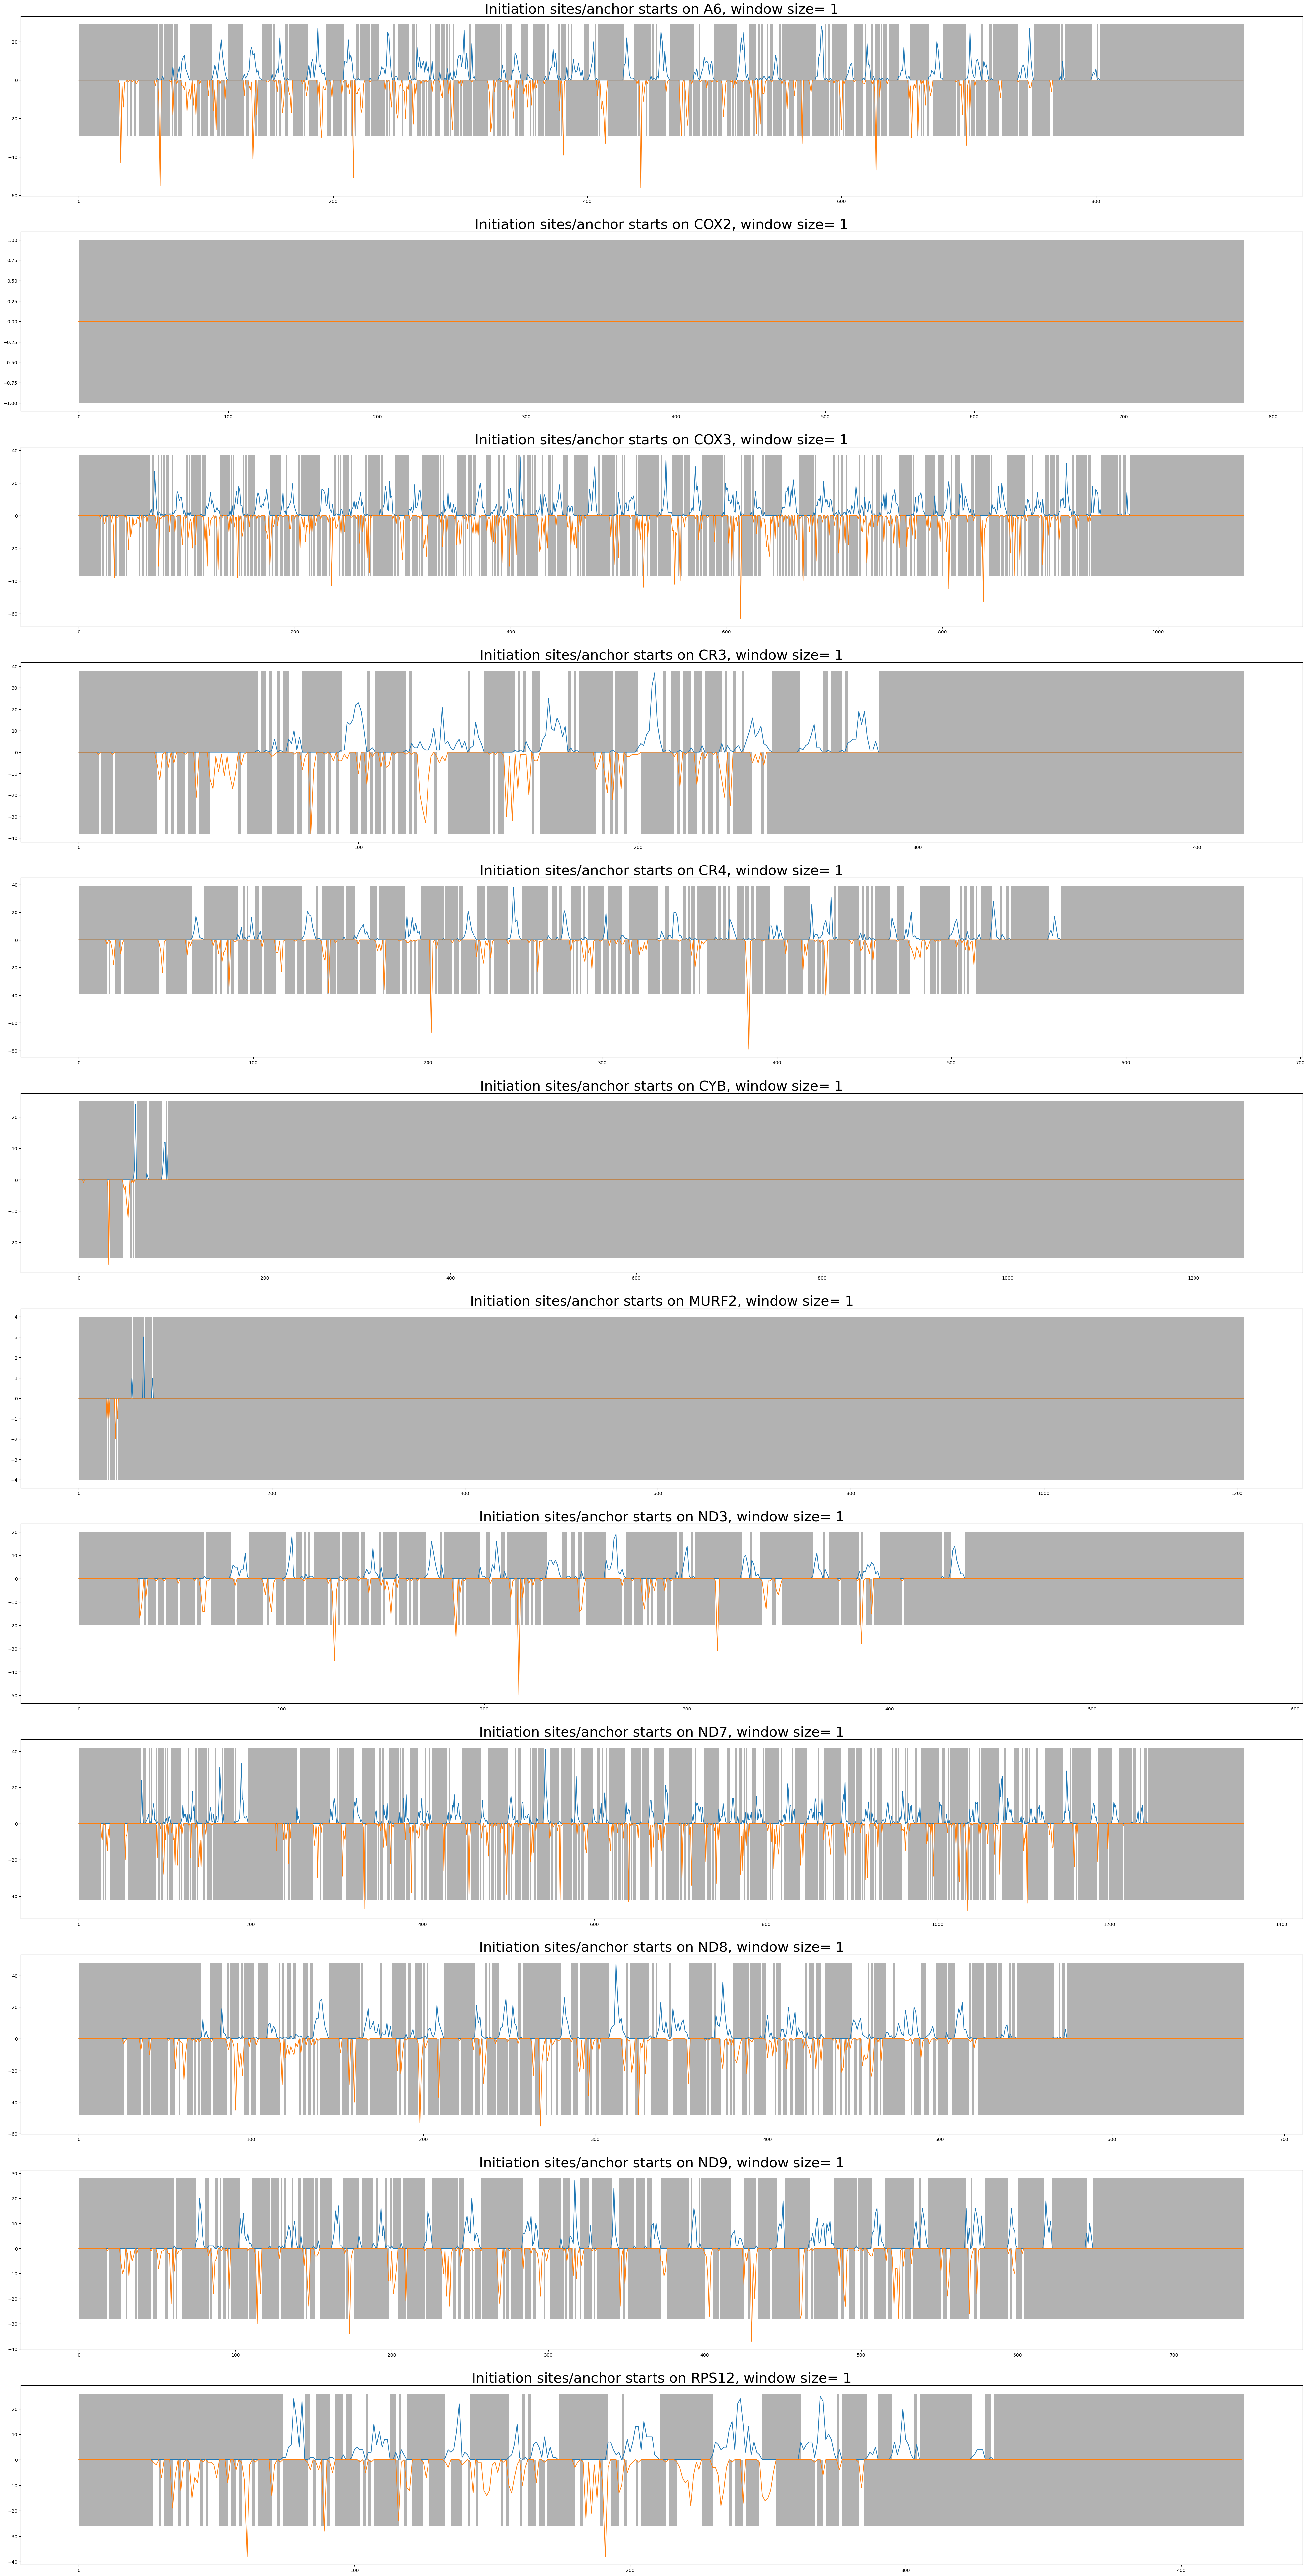

In [10]:
filename=f'/home/jovyan/Minicircle_gRNA_families/Work_files/{strain}/initiation_sites_{strain}.pdf'
counts=slide_window_plot(inits,anchors,filename,ws=1,figw=50,figh=100)

In [11]:
#make gRNA_family boundaries
def gRNA_family_boundaries(counts):
    gRNA_families={}
    for k in counts:
        #find boundaries
        mrna=''.join(['t' if i >9 else str(i) for i in counts[k]]) #one digit only real number count has 10 and can cause trouble
        starts=[match.start() for match in re.finditer('0{4,}',mrna)] #change from 3 to 1
        ends=[match.end() for match in re.finditer('0{4,}',mrna)]
        boundaries=[(i,j) for i,j in zip(ends[:-1],starts[1:])]
        gRNA_families[k]={f'{k}-{pair[0]}_{pair[1]}':{'bound':pair,'gRNA':[],'mRNA':k,'coverage':mrna[pair[0]:pair[1]]} for i,pair in enumerate(boundaries)}#','.join([str(i) for i in counts[k][pair[0]:pair[1]]])
        gRNA_families={m:{k: v for k, v in sorted(gRNA_families[m].items(), key=lambda item: item[1]['bound'][0])} for m in gRNA_families}
        #print(gRNA_families)     
    total=sum([len(v) for v in gRNA_families.values()])
    print(f"identified {total} anchor clusters")
    return(gRNA_families)
#subdivision
def subdivision(gRNA_families,mrna,k,ds):#ds are pieces of the coverage string
    bound=gRNA_families[mrna][k]['bound']
    for d in ds:
        start=re.search(d,gRNA_families[mrna][k]['coverage']).start()+gRNA_families[mrna][k]['bound'][0]
        end=start+len(d)
        name=f"{mrna}-{start}_{end}"
        gRNA_families[mrna][name]={'bound':(start,end),'gRNA':[],'mRNA':mrna,'coverage':d}
        print(gRNA_families[mrna][name])
    gRNA_families[mrna].pop(k)
#combine gRNA families
def gRNA_family_combine(gRNA_families,mrna,k1,k2):#k2 is downstream of k1
    start=gRNA_families[mrna][k1]['bound'][0]
    end=gRNA_families[mrna][k2]['bound'][1]
    name=f"{mrna}-{start}_{end}"
    gRNA_families[mrna][name]={'bound':(start,end),'gRNA':[],'mRNA':mrna,
                               'coverage':gRNA_families[mrna][k1]['coverage']+gRNA_families[mrna][k2]['coverage']}
    print(gRNA_families[mrna][name])
    gRNA_families[mrna].pop(k1)
    gRNA_families[mrna].pop(k2)
    
gRNA_families=gRNA_family_boundaries(counts)
subdivision(gRNA_families,'COX3','COX3-66_104',['2404tt401201001000','1102133tt9tt61300202'])
subdivision(gRNA_families,'COX3','COX3-382_415',['21335700','16400234ttt95110100','t9t011'])
subdivision(gRNA_families,'COX3','COX3-419_459',['101003134t05tt74','003028258ttt701','000562561'])
subdivision(gRNA_families,'COX3','COX3-681_738',['2066t9t28tt8t65t9400','120310012204231651','9tt302650t442973011'])
subdivision(gRNA_families,'CR4','CR4-499_517',['347tt60100','61001014'])
subdivision(gRNA_families,'ND7','ND7-848_867',['325788362tt20','6664t2'])
subdivision(gRNA_families,'ND7','ND7-935_980',['1220149t6304011','000101427tt40103t29t421','0001639'])
subdivision(gRNA_families,'ND8','ND8-110_145',['9t4861010','11002003212000200','19ttttt74'])
subdivision(gRNA_families,'ND8','ND8-244_258',['278tt91','7tt8001'])
subdivision(gRNA_families,'ND8','ND8-396_433',['2007t1401000','6614tt3','tt1745104000100031'])
subdivision(gRNA_families,'ND8','ND8-469_498',['4412013t632tt3','23tt5100','0123582'])
#subdivision(gRNA_families,'RPS12','RPS12-91_119',['11000200145440','33t6t588003042'])
#subdivision(gRNA_families,'','',[])
#combine
gRNA_family_combine(gRNA_families,'ND8','ND8-491_498','ND8-504_505')
gRNA_family_combine(gRNA_families,'ND9','ND9-188_201','ND9-206_207')
#sort again at the end
gRNA_families={m:{k: v for k, v in sorted(gRNA_families[m].items(), key=lambda item: item[1]['bound'][0])} for m in gRNA_families}
total=sum([len(v) for v in gRNA_families.values()])
print(f"identified {total} anchor clusters")

identified 234 anchor clusters
{'bound': (66, 84), 'gRNA': [], 'mRNA': 'COX3', 'coverage': '2404tt401201001000'}
{'bound': (84, 104), 'gRNA': [], 'mRNA': 'COX3', 'coverage': '1102133tt9tt61300202'}
{'bound': (382, 390), 'gRNA': [], 'mRNA': 'COX3', 'coverage': '21335700'}
{'bound': (390, 409), 'gRNA': [], 'mRNA': 'COX3', 'coverage': '16400234ttt95110100'}
{'bound': (409, 415), 'gRNA': [], 'mRNA': 'COX3', 'coverage': 't9t011'}
{'bound': (419, 435), 'gRNA': [], 'mRNA': 'COX3', 'coverage': '101003134t05tt74'}
{'bound': (435, 450), 'gRNA': [], 'mRNA': 'COX3', 'coverage': '003028258ttt701'}
{'bound': (450, 459), 'gRNA': [], 'mRNA': 'COX3', 'coverage': '000562561'}
{'bound': (681, 701), 'gRNA': [], 'mRNA': 'COX3', 'coverage': '2066t9t28tt8t65t9400'}
{'bound': (701, 719), 'gRNA': [], 'mRNA': 'COX3', 'coverage': '120310012204231651'}
{'bound': (719, 738), 'gRNA': [], 'mRNA': 'COX3', 'coverage': '9tt302650t442973011'}
{'bound': (499, 509), 'gRNA': [], 'mRNA': 'CR4', 'coverage': '347tt60100'}
{'b

In [12]:
#update family info and gRNA info
gRNA_dict2,gRNA_families2=assign_gRNA_families(gRNA_dict,gRNA_families)
check_gRNA_number(gRNA_dict2,gRNA_families2)
#merge single element families that are short
#gRNA_families2=merge_gRNA_fam(gRNA_dict2,gRNA_families2)
check_gRNA_number(gRNA_dict2,gRNA_families2)
for g in gRNA_dict:
    gRNA_dict[g]['gRNA']=g

number of gRNA in gRNA family dict: 13700 
number of gRNA in gRNA dict:13700
number of gRNA in gRNA family dict: 13700 
number of gRNA in gRNA dict:13700


#manually cluster some families after checking gf distributions
clusters=[['A6_v1-169_170','A6_v1-183_188','A6_v1-192_193'],['A6_v1-383_384','A6_v1-388_390'],['A6_v1-539_540','A6_v1-547_548'],
          ['A6_v1-739_740','A6_v1-743_749'],['COX3-566_567','COX3-570_572'],['ND7-372_373','ND7-378_380'],
          ['ND9-188_192','ND9-195_196'],
          ['ND8_v1-308_312','ND8_v1-315_316']]
#gRNA_families2=manual_merge_gRNA_fam(gRNA_families2, clusters)
#manually drop some gRNA families?

mini_dominant_sp={}
for m in mini_presence:
    strains=[s.split('_')[0] for s in mini_presence[m]]
    tmp={strains.count(s):s for s in set(strains)}
    #find dominant subspecies
    dom=tmp[max(list(tmp.keys()))]
    mini_dominant_sp[m]=(dom,round(strains.count(dom)/len(strains),2)) 

filename=f'/home/jovyan/Minicircle_gRNA_families/Work_files/{strain}/gRNA_thin_visual_{strain}.pdf'
init_grna_comb(inits,gRNA_families2,gRNA_dict2,filename,figw=50,figh=100,color_by_subspecies=True)

In [13]:
gf_presence={}
for k in gRNA_families2:
    for gf in gRNA_families2[k]:
        total=[]
        for g in gRNA_families2[k][gf]['gRNA']:
            mini=gRNA_dict[g]['mO_name']
            total+=mini_presence.get(mini,[])
        total=set(total)
        gf_presence[gf]=round(len(total)/len(combined),2) #the ratio is used to color the patches for each gf

In [14]:
filename=f'/home/jovyan/Minicircle_gRNA_families/Work_files/{strain}/gRNA_combined_visual_{strain}.pdf'
init_grna_comb(inits,gRNA_families2,gRNA_dict2,gf_presence,filename,figw=100,figh=100,color_by_subspecies=False)

#visualize the distribution of gRNA families on mRNA and observe phasing
outfile=f'/home/jovyan/Minicircle_gRNA_families/Work_files/{strain}/gRNA_fam_distribution_{strain}.pdf'
gRNA_family_validation(gRNA_dict2,gRNA_families2,outfile,figw=200,figh=200)

In [15]:
#get minicircle class
mini_dict,mini_df=assign_gRNA_fam_to_mini(gRNA_dict2,gRNA_families2)

In [16]:
mini_families=make_minicircle_family(mini_dict)
#add mini_families info to gRNA_families
add_mini_fam_info(gRNA_families2,gRNA_dict2,mini_families)

In [17]:
for mrna in gRNA_families2:
    for gf in gRNA_families2[mrna]:
        rightmost=[int(gRNA_dict[g]['mRNA_end'])-6 for g in gRNA_families2[mrna][gf]['gRNA']]
        leftmost=[int(gRNA_dict[g]['mRNA_start']) for g in gRNA_families2[mrna][gf]['gRNA']]
        gRNA_families2[mrna][gf]['editing_range']=(min(leftmost),max(rightmost)-6)
gfam={gf:record for m,v in gRNA_families.items() for gf,record in v.items()}


In [18]:
print(f"{len(mini_dict)} out of 5668 minicircles are annotated, giving {len(gfam)} gRNA families and {len(mini_families)} mini families" )

5510 out of 5668 minicircles are annotated, giving 250 gRNA families and 881 mini families


#check if gRNA family is essential
#the code is poorly designed, but probably not needed either
def check_essential(gRNA_families,insertions):
    def calculate_gap(gRNA_families2,insertions,mrna,omit='False'):
        edits={mrna:[0 if i==1 else 1 for i in insertions[mrna]] for mrna in insertions}#1 for u insertions
        for gf in gRNA_families2[mrna]:
            if gf!=omit:
                coverage=gRNA_families2[mrna][gf]['editing_range']
                for i in range(coverage[0],min(coverage[1],len(edits[mrna]))):
                    edits[mrna][i]=0 #set insertions to 0
        return(sum(edits[mrna]))
    for mrna in gRNA_families:
        total_gaps=calculate_gap(gRNA_families2,insertions,mrna,omit='False')
        for gf in gRNA_families[mrna]:
            gaps=calculate_gap(gRNA_families2,insertions,mrna,omit=gf)
            if gaps>total_gaps:
                print(f"{gf} is essential")
                #continue
            else:
                #print(f"{gf} is not essential")
                continue
        print(mrna,total_gaps)
            
check_essential(gRNA_families,insertions)

filename=f'/home/jovyan/Minicircle_gRNA_families/Work_files/{strain}/gRNA_fam_divisions_{strain}.pdf'
plot_initiation_sites(inits,gRNA_families2,gRNA_dict2,combined,filename,figw=100,figh=100)

          I   II  III    IV    V  Orphan
A6      418  507   53   749  229      30
COX2      0    0    0     0    0       0
COX3   1188  957   32   678  366      28
CR3     356   51    0   269   34      13
CR4     298  536    0   200   11      43
CYB       0    1    0     0    0      71
MURF2     0    0    0     0    0       4
ND3      35  189   32   189   68      12
ND7     176  860   60  1004  495      34
ND8     633  280   20   447   91      38
ND9     259  350    8   384  130      23
RPS12   158  253    0   297   51       1


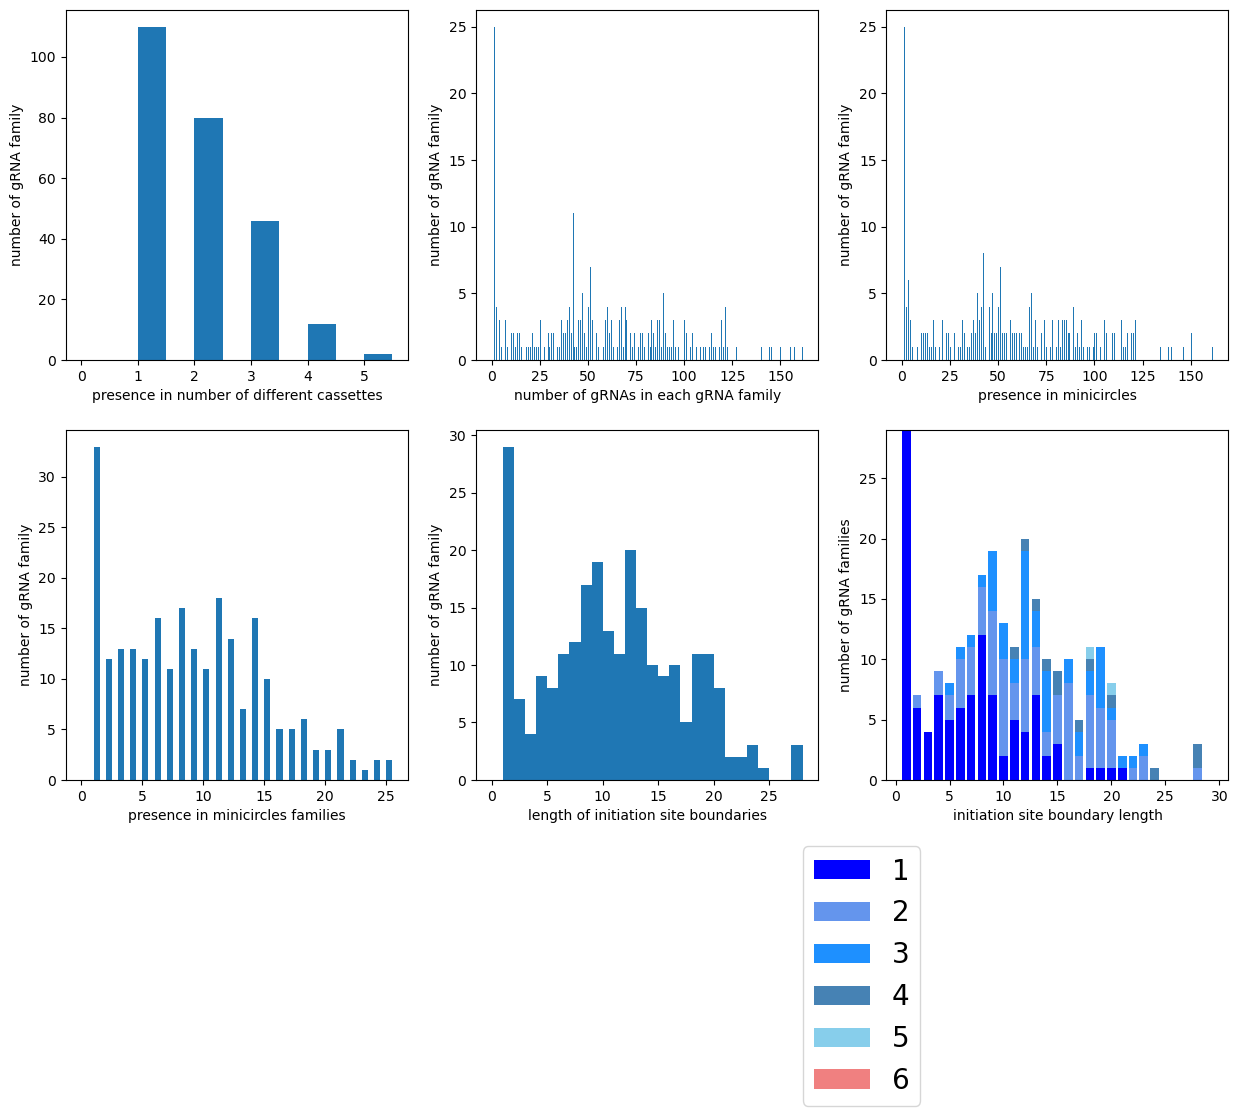

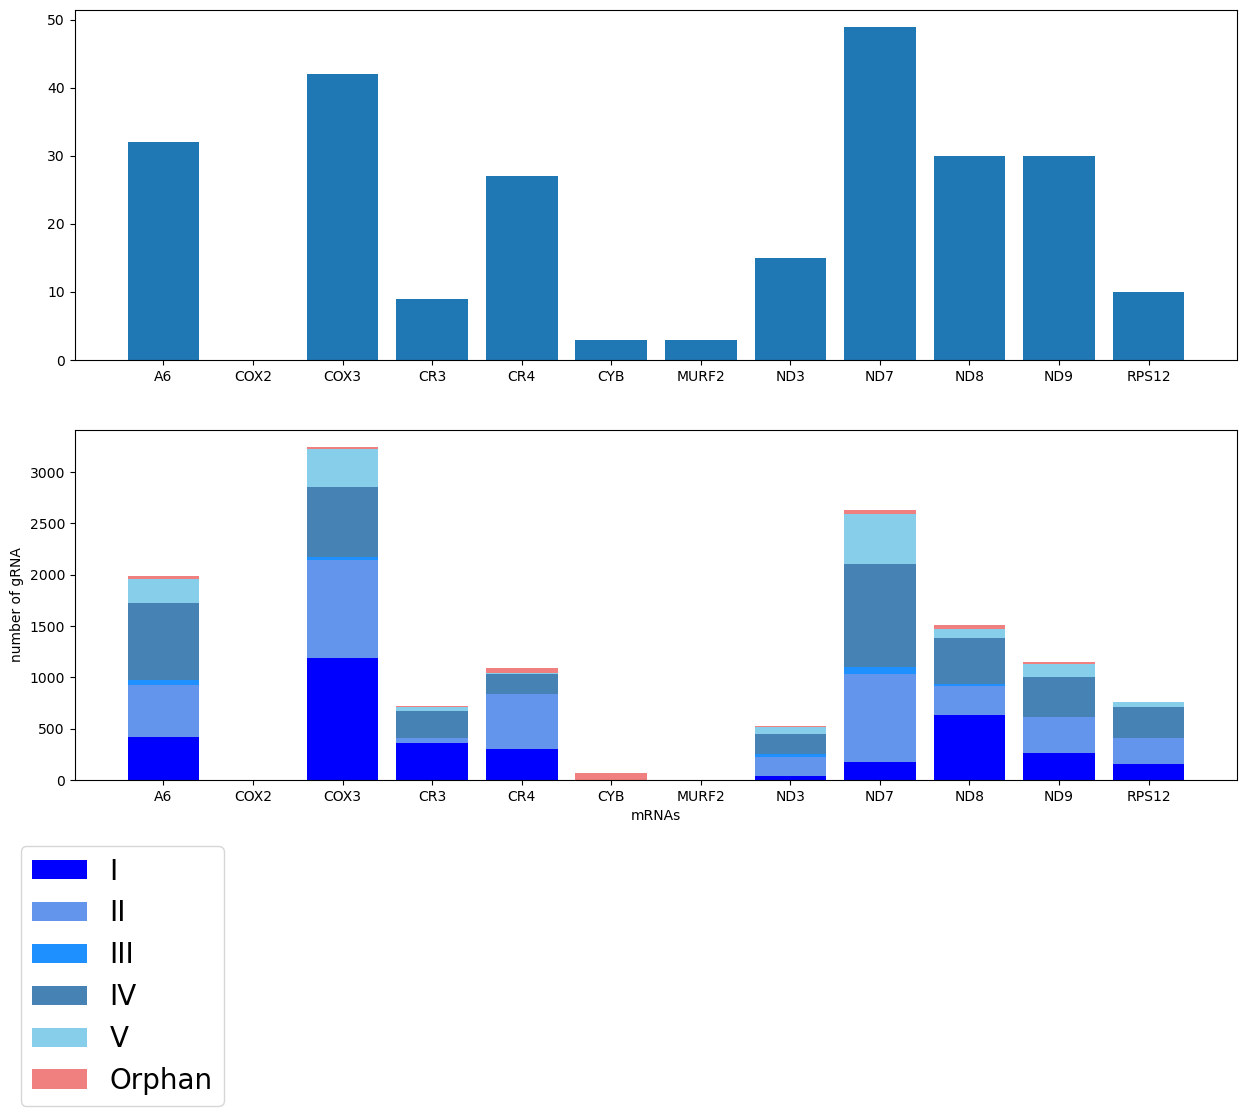

In [19]:
gRNA_family_stats(gRNA_dict2,gRNA_families2,figw=15,figh=10) #add 'cassette' to gRNA_families2

In [20]:
#output_gRNA_families(gRNA_families2,gRNA_dict2,threshold=3)
connections,shared,renamed_mini_family=connect_mini(mini_dict,mini_families)

In [21]:
#detect similar minicircles:
##if contains or is the subset of another minicircle family
##if no mismatches
##if shares >1 gRNA family and has <=1 mismatch
#if share 1 gRNA family and has <=1 mismatch
#connections,shared,renamed_mini_family=connect_mini(mini_dict,mini_families)
#turns out sharing 3 gFam at most
#output a xls file for searching minicircle families
csv_out=f'/home/jovyan/Minicircle_gRNA_families/Work_files/{strain}/minicircle_families.csv'
tmp={k:{c:v for c,v in zip(cassettes,renamed_mini_family[k]['cassettes'].split(';'))} for k in renamed_mini_family}
df=pd.DataFrame.from_dict(tmp,orient='index')
df.to_csv(csv_out)

In [22]:
#pickle_out(vars(),outfile)
selected={f'gRNA_dict':gRNA_dict2,f'gRNA_families':gRNA_families2,
          f'mini_dict':mini_dict,f'renamed_mini_family':renamed_mini_family}
pickleout=f'/home/jovyan/Minicircle_gRNA_families/Work_files/{strain}/{strain}_updated_4_dicts_0829.pickle'
pickle_out(selected,pickleout)

dump gRNA_dict
dump gRNA_families
dump mini_dict
dump renamed_mini_family
[]
5


In [23]:
gRNA_families2['ND3'].keys()

dict_keys(['ND3-62_63', 'ND3-75_84', 'ND3-102_116', 'ND3-129_130', 'ND3-138_150', 'ND3-157_158', 'ND3-171_180', 'ND3-198_211', 'ND3-231_249', 'ND3-260_270', 'ND3-295_304', 'ND3-327_336', 'ND3-362_370', 'ND3-385_395', 'ND3-426_437'])

In [24]:
gRNA_families2['ND3'].keys()
set([v['gRNA_family'][0] for v in gRNA_dict2.values() if 'ND3' in v['gRNA_family'][0]])

{'ND3-102_116',
 'ND3-129_130',
 'ND3-138_150',
 'ND3-157_158',
 'ND3-171_180',
 'ND3-198_211',
 'ND3-231_249',
 'ND3-260_270',
 'ND3-295_304',
 'ND3-327_336',
 'ND3-362_370',
 'ND3-385_395',
 'ND3-426_437',
 'ND3-62_63',
 'ND3-75_84'}

#plot network for individual gRNA family and minicircle family
date = datetime.datetime.now().strftime("%Y-%m-%d")
for gf in [g for k in gRNA_families2 for g in gRNA_families2[k]]:
    out=f'/home/jovyan/Minicircle_gRNA_families/Work_files/{strain}/Mini_fam_network_per_gRNA_fam/{strain}_{gf}.pdf'
    G=selected_g_m_family_network(gRNA_families2,renamed_mini_family,gRNA_dict2,[gf],colors=colors)
    plot_network(out, G)

In [25]:
renamed_mini_family['mFam_0']

{'cassettes': 'A6-284_312;ND7-99_107;n;ND3-171_180;ND7-429_446;CR4-301_303',
 'class': ['Tb_mO_1103', 'Tb_mO_738', 'Tb_mO_735', 'Tb_mO_841', 'Tb_mO_1358']}

In [26]:
print(renamed_mini_family['mFam_97'])
print(renamed_mini_family['mFam_304'])
print(renamed_mini_family['mFam_332'])
print(renamed_mini_family['mFam_149'])

{'cassettes': 'COX3-435_450;CR4-158_167;n;n;ND7-72_92;COX3-279_293', 'class': ['Tb_mO_707']}
{'cassettes': 'n;A6-180_194;n;RPS12-74_86;n;ND3-75_84', 'class': ['Tb_mO_3870']}
{'cassettes': 'ND8-368_380;ND7-541_550;n;CR3-94_106;n;n', 'class': ['Tb_mO_5275']}
{'cassettes': 'COX3-472_485;CR4-556_563;n;COX3-279_293;n;n', 'class': ['Tb_mO_1141', 'Tb_mO_4324', 'Tb_mO_1411', 'Tb_mO_2326', 'Tb_mO_2336', 'Tb_mO_2342', 'Tb_mO_2435', 'Tb_mO_2448', 'Tb_mO_2535', 'Tb_mO_2546', 'Tb_mO_2585', 'Tb_mO_2713', 'Tb_mO_3024', 'Tb_mO_3127', 'Tb_mO_3264', 'Tb_mO_3327', 'Tb_mO_3461', 'Tb_mO_3786', 'Tb_mO_3885', 'Tb_mO_4006', 'Tb_mO_4299', 'Tb_mO_1599', 'Tb_mO_1629', 'Tb_mO_1781']}
